# Performance Comparison

## Map Generation

In [1]:
# Imports

import os
import pickle
import numpy as np

from swarm_prm.utils.gaussian_prm import GaussianPRM
from swarm_prm.utils.gaussian_utils import GaussianGraphNode
from swarm_prm.envs.roadmap import Roadmap, Obstacle 
from swarm_prm.envs.instance import Instance

### Empty Map

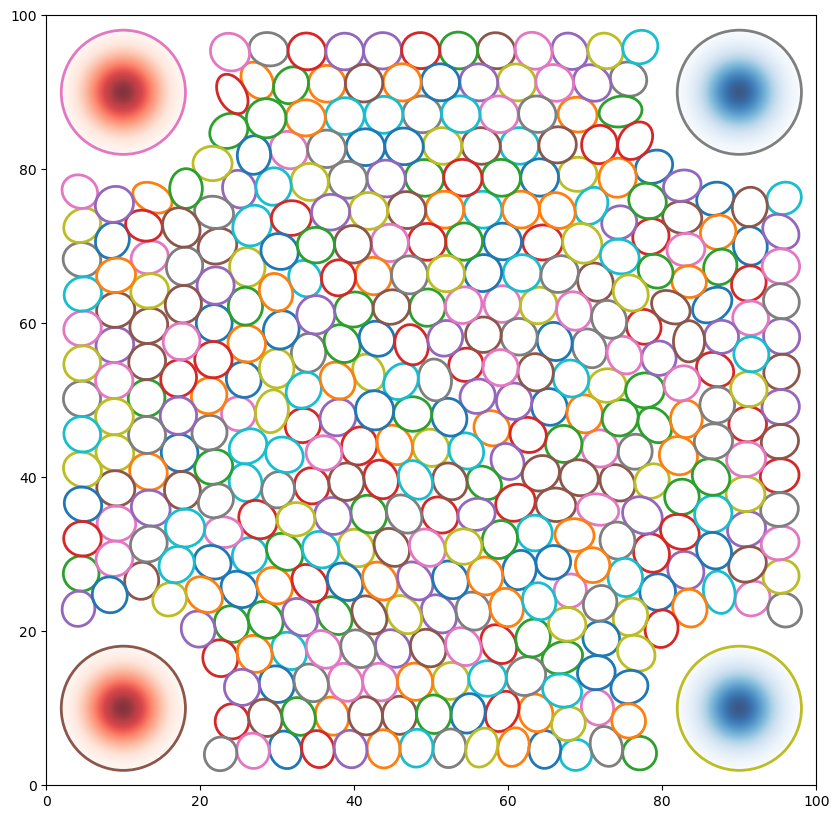

In [2]:
roadmap = Roadmap(100, 100)
safety_radius = 2 
pos = np.array([50, 50])
obstacles  = []

num_samples = 400

for obs in obstacles:
    roadmap.add_obstacle(obs)
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

# Agent config
sampling_method = "GAUSSIAN_SAMPLING"
hex_radius = 3
TEST_CVAR = False


# Curated test instance
starts = np.array([[10, 10], [10, 90]])
goals = np.array([[90, 90], [90, 10]])

starts_weight = np.array([.5, .5])
goals_weight = np.array([.5, .5])

g_starts = [GaussianGraphNode(start, None, "UNIFORM", radius=10) for start in starts]
g_goals = [GaussianGraphNode(goal, None, "UNIFORM", radius=10) for goal in goals]

instance = Instance(roadmap, g_starts, g_goals, starts_weight, goals_weight)

gaussian_prm = GaussianPRM(instance, num_samples, safety_radius=safety_radius,
                           hex_radius=hex_radius)
gaussian_prm.roadmap_construction()
gaussian_prm.visualize_g_nodes()
map_fname = "empty_{}.pkl".format(num_samples)

path = os.path.join("maps", map_fname)

with open(path, "wb") as f:
    pickle.dump(gaussian_prm, f)


### Corridor Map

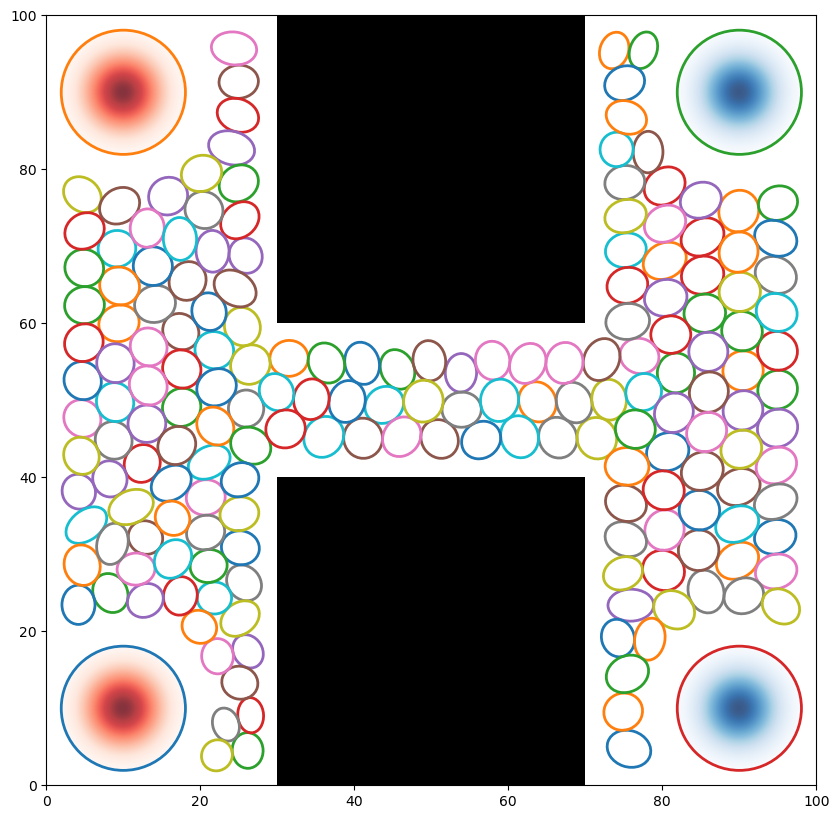

In [3]:
roadmap = Roadmap(100, 100)
safety_radius = 2 
pos = np.array([50, 50])
obstacles  = [
    Obstacle(None, "POLYGON", [(30, 0), (30, 40), (70, 40), (70, 0)]),
    Obstacle(None, "POLYGON", [(30, 100), (30, 60), (70, 60), (70, 100)])
]
num_samples = 200
for obs in obstacles:
    roadmap.add_obstacle(obs)
# fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

# Agent config
sampling_method = "GAUSSIAN_SAMPLING"
hex_radius = 3
TEST_CVAR = False


# Curated test instance
starts = np.array([[10, 10], [10, 90]])
goals = np.array([[90, 90], [90, 10]])

starts_weight = np.array([.5, .5])
goals_weight = np.array([.5, .5])

g_starts = [GaussianGraphNode(start, None, "UNIFORM", radius=10) for start in starts]
g_goals = [GaussianGraphNode(goal, None, "UNIFORM", radius=10) for goal in goals]

instance = Instance(roadmap, g_starts, g_goals, starts_weight, goals_weight)

gaussian_prm = GaussianPRM(instance, num_samples, safety_radius=safety_radius,
                           hex_radius=hex_radius)
gaussian_prm.roadmap_construction()
gaussian_prm.visualize_g_nodes()


map_fname = "corridor_{}.pkl".format(num_samples)
path = os.path.join("maps", map_fname)
with open(path, "wb") as f:
    pickle.dump(gaussian_prm, f)


### Obstacle Map

In [4]:
# Replicate of map from SwarmCVT

roadmap = Roadmap(200, 160)
safety_radius = 2 
pos = np.array([50, 50])
obstacles  = [
    Obstacle(None, "POLYGON", [(50, 0), (60, 75), (75, 75), (90, 40), (90, 0)]),
    Obstacle(None, "POLYGON", [(50, 130), (75, 127), (80, 100), (55, 103)]),
    Obstacle(None, "POLYGON", [(100, 150), (140, 150), (140, 125), (110, 125)]),
    Obstacle(None, "POLYGON", [(145, 25), (125, 50), (135, 100), (150, 100), (160, 75), (150, 25)])
]

num_samples = 200 
for obs in obstacles:
    roadmap.add_obstacle(obs)
sampling_method = "GAUSSIAN_SAMPLING"
hex_radius = 6


# Curated test instance
starts = np.array([[25, 25], [25, 125]])
goals = np.array([[175, 125], [175, 50]])

starts_weight = np.array([.5, .5])
goals_weight = np.array([.3, .7])

g_starts = [GaussianGraphNode(start, None, "UNIFORM", 10) for start in starts]
g_goals = [GaussianGraphNode(goal, None, "UNIFORM", 10) for goal in goals]

instance = Instance(roadmap, g_starts, g_goals, starts_weight, goals_weight)

gaussian_prm = GaussianPRM(instance, num_samples, safety_radius=safety_radius,
                           hex_radius=hex_radius)
gaussian_prm.roadmap_construction()

map_fname = "obstacle_{}.pkl".format(num_samples)
path = os.path.join("maps", map_fname)
with open(path, "wb") as f:
    pickle.dump(gaussian_prm, f)

### 

## Performance Testing

In [31]:
# Agent config
num_agent = 500
agent_radius = 0.5

# Map config
map_type = "corridor"
# num_samples = 50
# num_samples = 100
num_samples = 200
# num_samples = 400

In [32]:
# Load map

import os
import pickle

map_fname = "{}_{}.pkl".format(map_type, num_samples)
fname = os.path.join("maps", map_fname)
with open(fname, "rb") as f:
    gaussian_prm = pickle.load(f)

In [33]:
# TEG
from swarm_prm.solvers.macro.mcf import TEG_MCF

teg_graph= TEG_MCF(gaussian_prm, agent_radius, num_agents=num_agent, max_timestep=500)
timestep, flow_dict= teg_graph.get_earliest_timestep()

Time step:  21 Max Flow:  142 Cost:  18392.78617356536
Time step:  22 Max Flow:  399 Cost:  51788.82032881726
Time step:  23 Max Flow:  500 Cost:  64891.62657383092


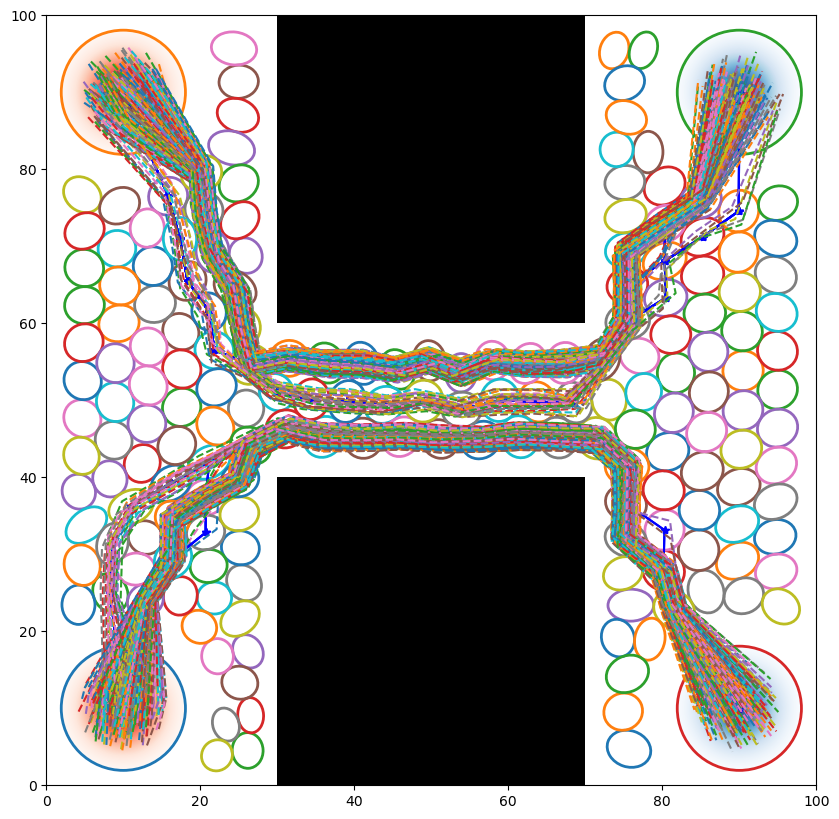

In [34]:
from matplotlib import pyplot as plt
from swarm_prm.solvers.micro import GaussianTrajectorySolver

simple_paths, _ = gaussian_prm.get_solution(flow_dict, timestep, num_agent)
macro_solution = gaussian_prm.get_macro_solution(flow_dict)

timestep = max(macro_solution.keys())

gt_solver = GaussianTrajectorySolver(gaussian_prm, macro_solution, timestep, num_agent, safety_gap=0)
gt_paths = gt_solver.solve()
fig, ax = gaussian_prm.visualize_g_nodes()

for path in simple_paths:
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-*', label='Path', color='blue')
# 
cmap = plt.get_cmap("tab10")
# 
for i, path in enumerate(gt_paths):
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '--', label='Path', color=cmap(i%10))

plt.show()

In [5]:
# DRRT 
from swarm_prm.solvers.macro.drrt import DRRT

drrt_solver = DRRT(gaussian_prm, agent_radius, num_agent)
path, cost= drrt_solver.get_solution()


ModuleNotFoundError: No module named 'swarm_prm.solvers.utils'

## Export Results